# Analyse the Grid Search model fitting

In [1]:
import sys
sys.path.append('/mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject')

import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json
from scipy.interpolate import CubicSpline
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from typing import Iterable

from import_data import BailerJones
from model_functions import *
from functions import import_spectra, extract_spectrum_within_range

##### Some handy functions

In [2]:
def extract_vsini(vsini:str)->int:
    """
    Takes a string like 'vsini###'
    This function extracts the number

    Args:
        vsini (str): String like 'vsini###'

    Returns:
        int: The number in the string
    """
    return int(re.search(r'\d+$', vsini).group())

##### Import the data

In [3]:
# Load the JSON file
with open('FitResults/Cen X-3S120E250delta5.json', 'r') as json_file:
    grid_result = json.load(json_file)

- Take the minimun $\chi^{2}$ value for every value of vsin(i):  <strong> min_chi2_list </strong>
- Save every vsin(i): <strong> vsini_list </strong>
- For every vsin(i) save the name of the best model: <strong> best_models </strong>

In [4]:
vsini_list = []
min_chi2_list = []
best_models = []

for vsini, chi2 in grid_result.items():
    vsini_list.append(extract_vsini(vsini))
    min_chi2_list.append(chi2[min(chi2, key=chi2.get)])
    best_models.append(min(chi2, key=chi2.get))

##### First result

In [5]:
# Object name
object_name = 'Cen X-3'

# Best vsin(i)
vsini_best = list(grid_result.keys())[min_chi2_list.index(min(min_chi2_list))]

# All chi2 values of the best vsin(i)
chi2_best = grid_result[vsini_best]

# Best model of the best vsin(i)
best_model = min(chi2_best, key=chi2_best.get)

print(f"The minimum chi-squared: \t {round(chi2_best[min(chi2_best, key=chi2_best.get)], 4)}")
print(f"The best vsin(i): \t\t {extract_vsini(vsini_best)} km/s")
print(f"This is for model: \t\t {best_model}")

The minimum chi-squared: 	 4.4598
The best vsin(i): 		 205 km/s
This is for model: 		 T27000logg3.2


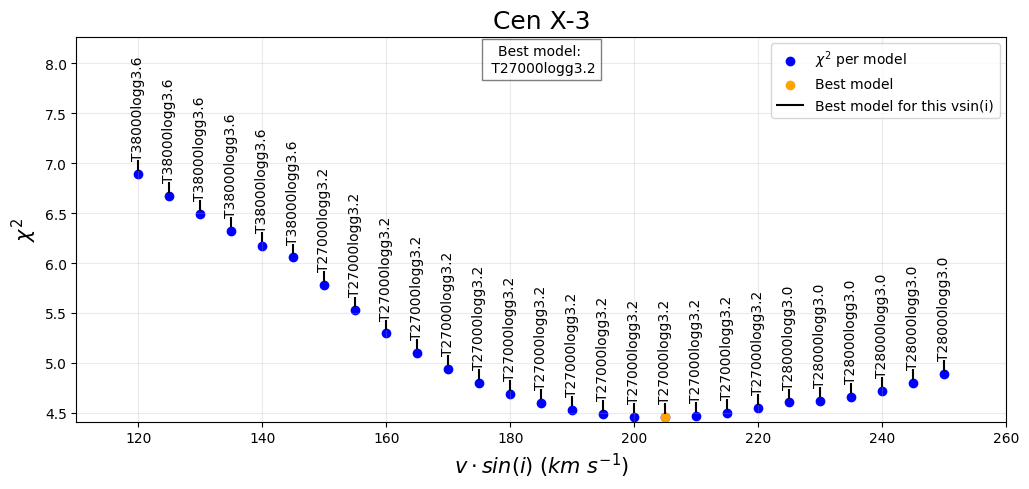

In [6]:
plt.figure(figsize=(12,5))
plt.scatter(vsini_list, min_chi2_list, color='blue', label=r'$\chi^{2}$ per model')
plt.scatter(extract_vsini(vsini_best), chi2_best[best_model], color='orange', label='Best model')

plt.text(0.5, 0.94, f'Best model: \n {best_model}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Annotate each line with text vertically
plt.vlines(vsini_list, 
           ymin=np.array(min_chi2_list) + max(min_chi2_list) / 200, 
           ymax=np.array(min_chi2_list) + max(min_chi2_list) / 50, 
           color='black', label='Best model for this vsin(i)')

for (x, y, best_model_) in zip(vsini_list, min_chi2_list, best_models):
    plt.text(x, y + max(min_chi2_list) / 50, 
             f'{best_model_}', ha='center', va='bottom', rotation=90, size=10)

plt.title("Cen X-3", fontsize=18)
plt.ylabel(r'$\chi^{2}$', fontsize=15)
plt.xlabel(r'$v \cdot sin(i)$ ($km$ $s^{-1}$)', fontsize=15)

plt.xlim(min(vsini_list) - 10, max(vsini_list) + 10)
plt.ylim(min(min_chi2_list) * 0.99, max(min_chi2_list) * 1.2)

plt.grid(alpha=0.25)
plt.legend(loc='best')

# plt.savefig("../Plots/GridSearchAnalysisCenX_3.png")

plt.show()

##### How does the $\chi^{2}$ distribution look for just the best model

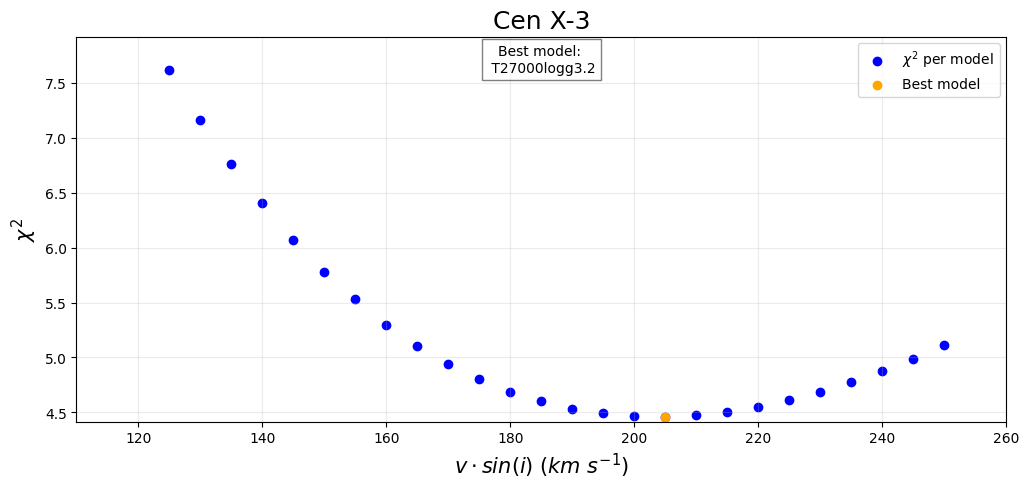

In [7]:
vsini_list_best = []
min_chi2_list_best = []

for vsini, chi2 in grid_result.items():
    vsini_list_best.append(extract_vsini(vsini))
    min_chi2_list_best.append(chi2[best_model])

plt.figure(figsize=(12,5))
plt.scatter(vsini_list_best, min_chi2_list_best, color='blue', label=r'$\chi^{2}$ per model')
plt.scatter(extract_vsini(vsini_best), chi2_best[best_model], color='orange', label='Best model')

plt.text(0.5, 0.94, f'Best model: \n {best_model}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.title("Cen X-3", fontsize=18)
plt.ylabel(r'$\chi^{2}$', fontsize=15)
plt.xlabel(r'$v \cdot sin(i)$ ($km$ $s^{-1}$)', fontsize=15)

plt.xlim(min(vsini_list) - 10, max(vsini_list) + 10)
plt.ylim(min(min_chi2_list) * 0.99, max(min_chi2_list) * 1.15)

plt.grid(alpha=0.25)
plt.legend(loc='best')

# plt.savefig("../Plots/GridSearchAnalysisCenX_3.png")

plt.show()

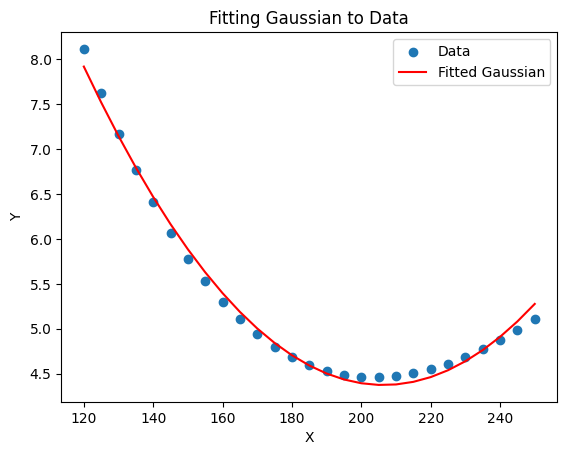

Amplitude: -19575.285590861597
Mean: 206.40117419578365
Standard Deviation: 4540.039017298294
Continuum: 19579.659580086536


In [15]:
# Fit the Gaussian curve to the data
initial_guess = [extract_vsini(vsini_best), 10, 20, 10]  # Initial guess for amplitude, mean, and stddev
params, covariance = curve_fit(gaussian, vsini_list_best, min_chi2_list_best, p0=initial_guess)

# Extract the parameters
mean, amplitude,stddev, height = params

# Plot the original data and the fitted Gaussian curve
plt.scatter(vsini_list_best, min_chi2_list_best, label='Data')
plt.plot(vsini_list_best, gaussian(vsini_list_best, mean, amplitude, stddev, height), color='red', label='Fitted Gaussian')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting Gaussian to Data')
plt.show()

print("Amplitude:", amplitude)
print("Mean:", mean)
print("Standard Deviation:", stddev)
print("Continuum:", height)